In [1]:
from NO_utils import extract_data, plot_geometry, plot_eigenvectors
import os
import matplotlib.pyplot as plt
import numpy as np
import random

## Load and visualize data

In [2]:
# Load and extract data
datafolder_name = ["OUTPUT", "discrete_symmetric_p32_n400_rs0"]
data_path = os.path.join(*datafolder_name)
print(data_path)

designs, design_params, n_designs, n_panes, design_res, WAVEVECTOR_DATA, n_dim, n_wavevectors, EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x, EIGENVECTOR_DATA_y, const, N_struct, imag_tol, rng_seed_offset = extract_data(data_path)

OUTPUT\discrete_symmetric_p32_n400_rs0
Data loaded in 457.38 seconds.
n_designs: 400, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[0.]]
EIGENVALUE_DATA shape: (400, 325, 6)
EIGENVECTOR_DATA shape: (400, 325, 6, 2048)
EIGENVECTOR_DATA_x shape: (400, 325, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (400, 325, 6, 32, 32)
WAVEVECTOR_DATA shape: (400, 325, 2)
designs shape: (400, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'isSaveEigenvectors': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson_min': (1, 1), 'rho_max': (1, 1), 'rho_min': (1, 1), 'sigma_eig': (1, 1), 'symmetry_type': (4, 1), 't': (1, 1), 'wavevectors': (2, 325)}


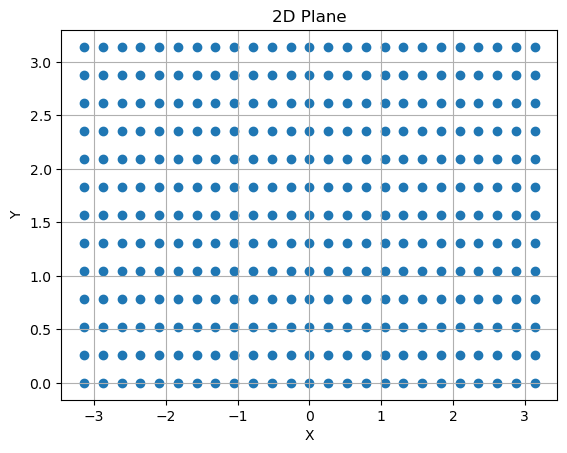

In [3]:
# View distribution of wavevectors in 2D plane
fig, ax = plt.subplots()
ax.scatter(WAVEVECTOR_DATA[0,:,0], WAVEVECTOR_DATA[0,:,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Plane')
ax.grid(True)
plt.show()

In [4]:
# Draw a random design and its corresponding eigenvectors
random_seed = 100
random.seed(random_seed)
sample_index = np.random.randint(0, n_designs)
sample_geometry = designs[sample_index, 0]
sample_band = np.random.randint(0, n_bands)
sample_wavevector = np.random.randint(0, n_wavevectors)
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_wavevector}')

Design: 95, Band: 2, Wavevector: 28


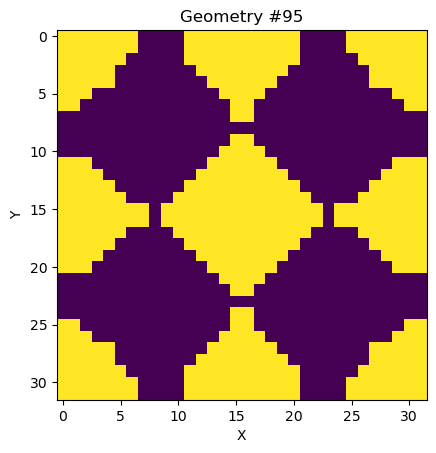

Wavevector index: 28, components: [-2.617   0.5234]


In [5]:
# View a geometry design
plot_geometry(sample_geometry, sample_index)
print(f'Wavevector index: {sample_wavevector}, components: {WAVEVECTOR_DATA[sample_index,sample_wavevector]}')

Design: 95, Band: 2, Wavevector: 28


A:\Research\Projects\NO 2D Metamaterials\NO_utils.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


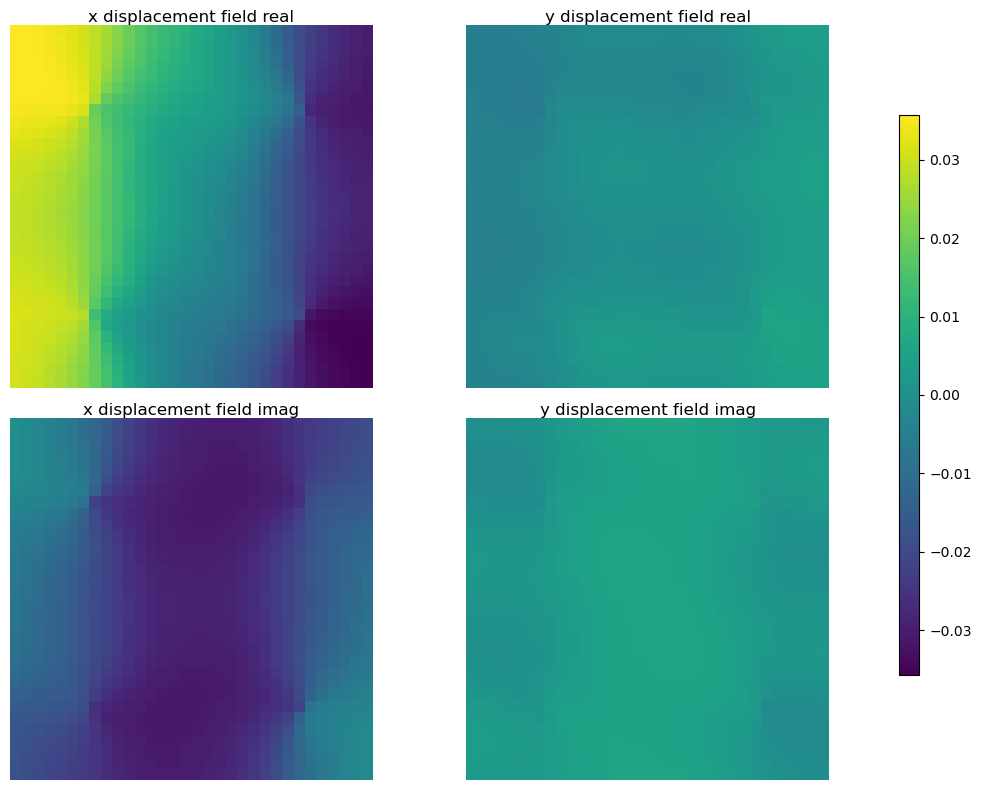

In [6]:
# View eigenvectors for the selected design, band, and wavevector
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_wavevector}')
sample_eigenvector_x = EIGENVECTOR_DATA_x[sample_index, sample_wavevector, sample_band]
sample_eigenvector_y = EIGENVECTOR_DATA_y[sample_index, sample_wavevector, sample_band]

plot_eigenvectors(sample_eigenvector_x, sample_eigenvector_y, unify_scales=True)

## Define model architecture

In [23]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO, FNO2d, TFNO2d
from neuralop import Trainer
from neuralop.training import CheckpointCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.datasets import data_transforms
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# For handling file paths and directories
import os
import sys
import h5py

# Optional: If your model or data processing requires specific numerical operations (e.g., FFT)
from torch.fft import fft, ifft

# Optional: If you are working with graph data or architectures
# import torch_geometric

# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function

In [8]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.1.0


In [10]:
# Prepare input data
num_samples = n_designs * n_wavevectors * n_bands
input_data = torch.zeros((num_samples, 4, design_res, design_res))

for i in range(n_designs):
    for j in range(n_wavevectors):
        for k in range(n_bands):
            sample_idx = i * n_wavevectors * n_bands + j * n_bands + k
            input_data[sample_idx, 0] = torch.from_numpy(designs[i, 0])
            input_data[sample_idx, 1] = torch.tensor(WAVEVECTOR_DATA[0, j, 0], dtype=torch.float32)
            input_data[sample_idx, 2] = torch.tensor(WAVEVECTOR_DATA[0, j, 1], dtype=torch.float32)
            input_data[sample_idx, 3] = k + 1

# Prepare output data
output_data = torch.zeros((num_samples, 4, design_res, design_res))

for i in range(n_designs):
    for j in range(n_wavevectors):
        for k in range(n_bands):
            sample_idx = i * n_wavevectors * n_bands + j * n_bands + k
            output_data[sample_idx, 0] = torch.from_numpy(EIGENVECTOR_DATA_x[i, j, k].real)
            output_data[sample_idx, 1] = torch.from_numpy(EIGENVECTOR_DATA_x[i, j, k].imag)
            output_data[sample_idx, 2] = torch.from_numpy(EIGENVECTOR_DATA_y[i, j, k].real)
            output_data[sample_idx, 3] = torch.from_numpy(EIGENVECTOR_DATA_y[i, j, k].imag)

# Create dataset
dataset = TensorDataset(input_data, output_data)

# Split dataset into train, test, and validation sets
train_size = int(0.75 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Print the shapes of the input and output data, train, test, and validation sets
print('Input data shape:', input_data.shape)
print('Output data shape:', output_data.shape)
print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

Input data shape: torch.Size([780000, 4, 32, 32])
Output data shape: torch.Size([780000, 4, 32, 32])
Train data size: 585000
Test data size: 156000
Validation data size: 39000


In [20]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, width=64):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.width = width  # Width of the fully connected layers

        # Define the lifting layer to map input channels to hidden channels
        self.fc0 = nn.Linear(4, self.width)

        # Define the Fourier neural operator (FNO) layer
        self.fno = FNO2d(num_channels=4, n_modes_height=self.modes_height, n_modes_width=self.modes_width,
                         hidden_channels=self.width, num_layers=4, num_timesteps=1)

        # Define the projection layer to map hidden channels to output channels
        self.fc1 = nn.Linear(self.width, 4)

    def forward(self, x):
        # Apply the lifting layer to map input channels to hidden channels
        x = self.fc0(x)

        # Reshape the input to add a time dimension (required by FNO2d)
        x = x.unsqueeze(-1)

        # Apply the Fourier neural operator (FNO) layer
        x = self.fno(x)

        # Remove the time dimension
        x = x.squeeze(-1)

        # Apply the projection layer to map hidden channels to output channels
        x = self.fc1(x)

        return x

Operating Principle of FNOs:
Fourier Neural Operators (FNOs) are a class of neural network architectures designed to learn the mapping between function spaces. They leverage the properties of the Fourier transform to efficiently learn and represent complex spatial-temporal relationships in data.
The key idea behind FNOs is to perform convolutions in the Fourier space rather than the spatial domain. By transforming the input data into the Fourier space using the Fourier transform, FNOs can capture global dependencies and long-range interactions more effectively compared to traditional convolutional neural networks (CNNs).
In the Fourier space, the convolution operation becomes a pointwise multiplication, which is computationally efficient. FNOs learn a set of Fourier coefficients that represent the learned operator in the Fourier space. These coefficients are then used to transform the input function and obtain the output function.
The architecture of an FNO typically consists of three main components:

Lifting layer: This layer maps the input channels to a higher-dimensional space (hidden channels) to increase the expressiveness of the network.
Fourier neural operator (FNO) layer: This layer performs the convolutions in the Fourier space. It applies the Fourier transform to the input, performs pointwise multiplications with the learned Fourier coefficients, and then applies the inverse Fourier transform to obtain the output.
Projection layer: This layer maps the hidden channels back to the desired output channels.

Modifying the Architecture for Performance:
There are several ways to modify the FNO architecture to potentially improve performance:

Increase the number of Fourier modes: Increasing the number of Fourier modes allows the FNO to capture finer details and higher-frequency components in the data. However, this also increases the computational complexity and memory requirements.
Adjust the width of the fully connected layers: Increasing the width of the lifting and projection layers can enhance the expressiveness of the network. However, this also increases the number of parameters and computational cost.
Increase the number of FNO layers: Adding more FNO layers can allow the network to learn more complex relationships and capture deeper hierarchical features. However, this also increases the depth of the network and may lead to vanishing or exploding gradients.
Experiment with different activation functions: The choice of activation functions can impact the learning dynamics and convergence of the network. Commonly used activation functions include ReLU, LeakyReLU, and ELU.
Incorporate skip connections: Skip connections, such as residual connections, can help alleviate the vanishing gradient problem and facilitate the flow of information across layers. They can be added between the lifting layer and the projection layer or within the FNO layers.
Apply regularization techniques: Regularization techniques, such as L1/L2 regularization or dropout, can help prevent overfitting and improve generalization performance.

In [28]:
# Set up training parameters and hyperparameters
num_epochs = 100
learning_rate = 0.001
modes = 16
width = 64

# Create an instance of the Fourier neural operator model
model = FourierNeuralOperator(modes, width).to(device)

# Define the loss function and optimizer
criterion = LpLoss(d=2, p=2)  # L2 loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Create a data transformer for normalization
#transformer = data_transforms.basic_transformer(scale=False, normalize=True)

# Create a Trainer instance and train the model
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  callbacks=[
                      CheckpointCallback(save_dir='./checkpoints',
                                         save_interval=10,
                                         save_optimizer=True,
                                         save_scheduler=True)
                  ],
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders={},
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=criterion)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Validation and visualization
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Select a random sample from the batch
        idx = np.random.randint(0, len(inputs))

        # Get the predicted eigenvectors
        pred_eigenvector_x_real = outputs[idx, 0].cpu().numpy()
        pred_eigenvector_x_imag = outputs[idx, 1].cpu().numpy()
        pred_eigenvector_y_real = outputs[idx, 2].cpu().numpy()
        pred_eigenvector_y_imag = outputs[idx, 3].cpu().numpy()

        # Combine the real and imaginary parts
        pred_eigenvector_x = pred_eigenvector_x_real + 1j * pred_eigenvector_x_imag
        pred_eigenvector_y = pred_eigenvector_y_real + 1j * pred_eigenvector_y_imag

        # Get the true eigenvectors
        true_eigenvector_x = labels[idx, 0].cpu().numpy() + 1j * labels[idx, 1].cpu().numpy()
        true_eigenvector_y = labels[idx, 2].cpu().numpy() + 1j * labels[idx, 3].cpu().numpy()

        # Visualize the predicted and true eigenvectors
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plot_eigenvectors(pred_eigenvector_x, pred_eigenvector_y, ax=axes[0], title='Predicted Eigenvectors')
        plot_eigenvectors(true_eigenvector_x, true_eigenvector_y, ax=axes[1], title='True Eigenvectors')
        plt.tight_layout()
        plt.show()
        break